In [31]:
import scanpy as sc
adata = sc.read_h5ad("fpkm_unstranded.h5ad") 
print("Shape of adata:", adata.shape)          
print("adata.obs:\n", adata.obs.head())         
print("adata.var:\n", adata.var.head())        


Shape of adata: (2008, 60660)
adata.obs:
 Empty DataFrame
Columns: []
Index: [00000c20-b875-4821-8d4b-c50d7a7f9879, 000b6b94-572d-4d06-a8f4-2e43829f83d4, 0052ae83-7ae5-470a-a125-5cd94a9fa9e9, 00810078-a4fc-4e1d-bbdc-e5e0d3080025, 00ad0370-5339-4136-800c-56d4250af0ab]
adata.var:
 Empty DataFrame
Columns: []
Index: [ENSG00000000003.15, ENSG00000000005.6, ENSG00000000419.13, ENSG00000000457.14, ENSG00000000460.17]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [32]:
import pandas as pd

# Load the label file
labels_df = pd.read_csv("labels.csv", sep='\t')  
labels_df = labels_df.set_index("FileID")        


In [33]:

adata.obs_names_make_unique()
adata.obs = pd.DataFrame(index=adata.obs_names)  

adata.obs = adata.obs.join(labels_df, how='left')


adata.obs['Label'] = adata.obs['SampleType'].replace({
    'Primary Tumor': 'disease',
    'Solid Tissue Normal': 'normal'
})


In [34]:
#checking labels in data
print(adata.obs['Label'].value_counts())


Label
disease                                                                      1488
normal                                                                        403
Primary Tumor, Primary Tumor                                                   64
Metastatic                                                                     16
Solid Tissue Normal, Solid Tissue Normal                                       11
Solid Tissue Normal, Solid Tissue Normal, Solid Tissue Normal                   8
Next Generation Cancer Model                                                    6
Primary Tumor, Primary Tumor, Primary Tumor                                     4
Recurrent Tumor                                                                 2
Slides                                                                          1
Expanded Next Generation Cancer Model                                           1
Primary Tumor, Primary Tumor, Primary Tumor, Primary Tumor, Primary Tumor       1
Not Report

In [35]:
#checking disease and normal samples
def clean_label(label):
    if pd.isna(label):
        return None
    label = label.lower()
    if "primary tumor" in label or "metastatic" in label or "recurrent" in label:
        return "disease"
    elif "solid tissue normal" in label:
        return "normal"
    else:
        return None 


adata.obs['CleanLabel'] = adata.obs['SampleType'].apply(clean_label)

adata = adata[~adata.obs['CleanLabel'].isna(), :]

print(adata.obs['CleanLabel'].value_counts())


CleanLabel
disease    1575
normal      422
Name: count, dtype: int64


In [36]:
#checking other labels

adata_all = sc.read_h5ad("fpkm_unstranded.h5ad")  
adata_all.obs = adata_all.obs.join(labels_df, how='left')  
adata_all.obs['CleanLabel'] = adata_all.obs['SampleType'].apply(clean_label)
unmapped = adata_all.obs[adata_all.obs['CleanLabel'].isna()]['SampleType'].unique()

print("Labels that were NOT mapped to 'disease' or 'normal':")
for label in unmapped:
    print("-", label)


Labels that were NOT mapped to 'disease' or 'normal':
- Next Generation Cancer Model
- Slides
- Expanded Next Generation Cancer Model
- Not Reported


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [37]:
#running random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

adata_clean = adata[adata.obs['CleanLabel'].isin(['disease', 'normal']), :]
X = adata_clean.X.toarray() if hasattr(adata_clean.X, 'toarray') else adata_clean.X
y = adata_clean.obs['CleanLabel']
#train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(" Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.99
 Classification Report:
               precision    recall  f1-score   support

     disease       0.99      1.00      0.99       315
      normal       0.99      0.96      0.98        85

    accuracy                           0.99       400
   macro avg       0.99      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


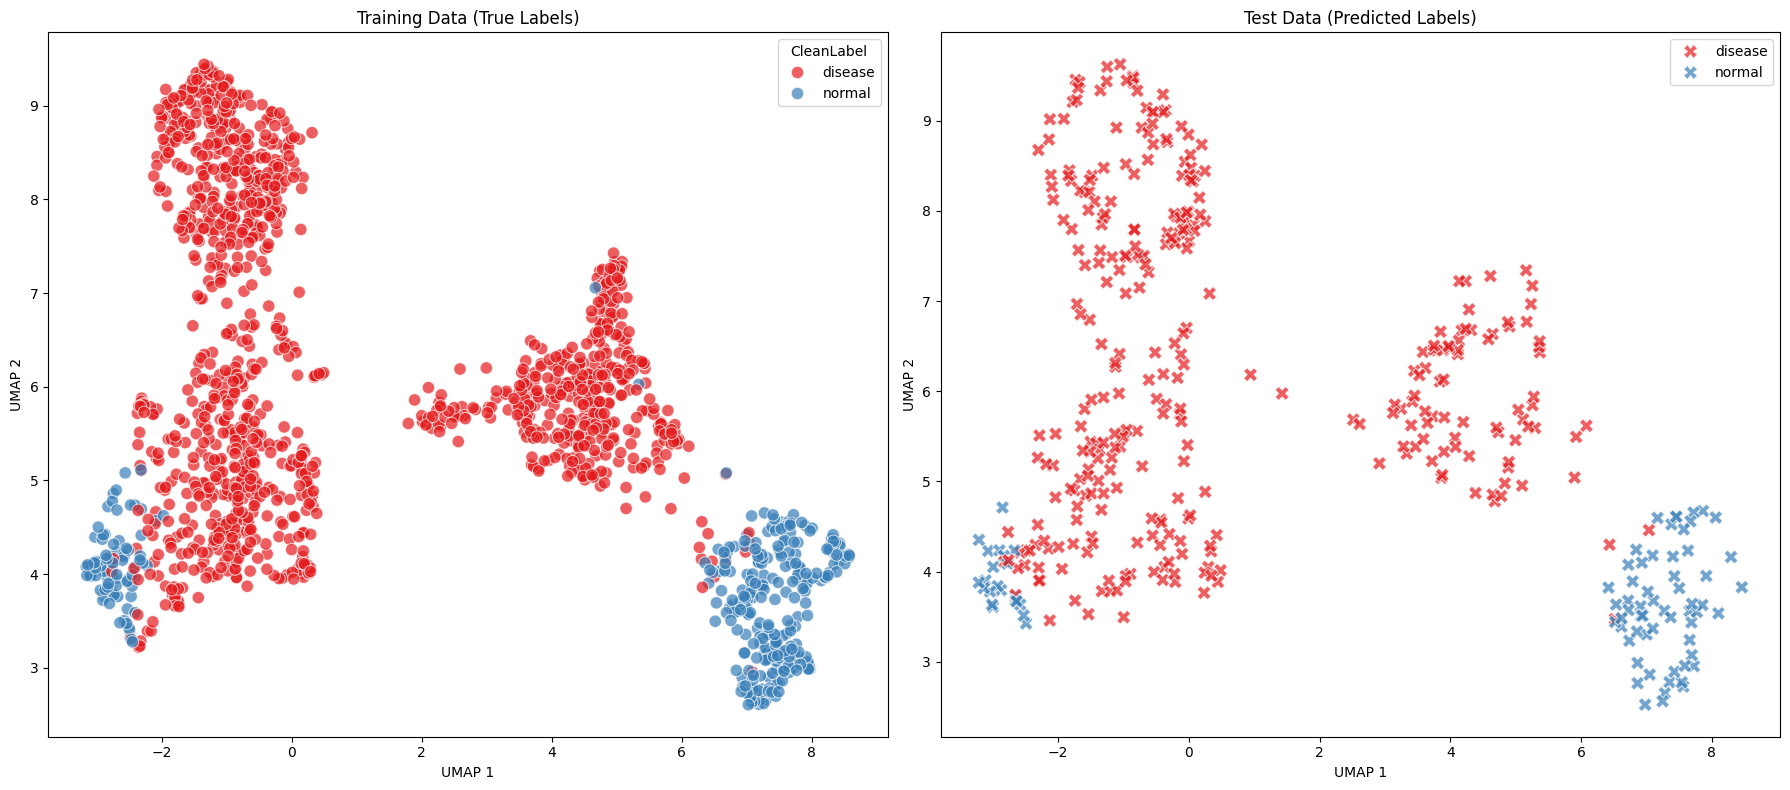

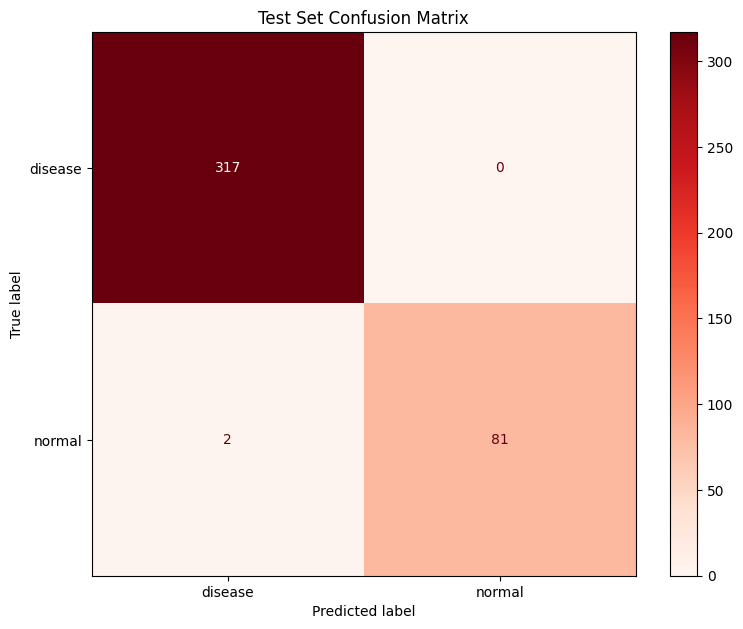

Test Set Classification
              precision    recall  f1-score   support

     disease       0.99      1.00      1.00       317
      normal       1.00      0.98      0.99        83

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



In [38]:
#UMAP for random forest classifier
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


#Running random forest classifier to classify disease and normal cases. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
X_train_umap = umap_model.fit_transform(X_train_scaled)
X_test_umap = umap_model.transform(X_test_scaled)

#Plotting the distribution with UMAP
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

train_df = pd.DataFrame({
    'UMAP1': X_train_umap[:, 0],
    'UMAP2': X_train_umap[:, 1],
    'Label': y_train,
    'Set': 'Training (Actual)'
})

test_df = pd.DataFrame({
    'UMAP1': X_test_umap[:, 0],
    'UMAP2': X_test_umap[:, 1],
    'Label': y_test_pred,
    'Set': 'Test (Predicted)'
})

plot_df = pd.concat([train_df, test_df])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(
    x=X_train_umap[:, 0],
    y=X_train_umap[:, 1],
    hue=y_train,
    palette="Set1",
    s=80,
    alpha=0.7,
    ax=ax1
)
ax1.set_title("Training Data (True Labels)")
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")

sns.scatterplot(
    x=X_test_umap[:, 0],
    y=X_test_umap[:, 1],
    hue=y_test_pred,
    palette="Set1",
    s=100,
    alpha=0.7,
    marker='X',
    ax=ax2
)
ax2.set_title("Test Data (Predicted Labels)")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))

#confusion matrix of test set
plt.subplot(122)
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_)
disp_test.plot(cmap='Reds', ax=plt.gca(), values_format='d')
plt.title("Test Set Confusion Matrix")

plt.tight_layout()
plt.show()

print("Test Set Classification")
print(classification_report(y_test, y_test_pred))

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

# Test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Print the results
print("\n=== Training Set Metrics ===")
print(f"Accuracy : {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall   : {train_recall:.4f}")
print(f"F1 Score : {train_f1:.4f}")

print("\n=== Test Set Metrics ===")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")



=== Training Set Metrics ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000

=== Test Set Metrics ===
Accuracy : 0.9950
Precision: 0.9969
Recall   : 0.9880
F1 Score : 0.9923


In [40]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report


adata = sc.read_h5ad("fpkm_unstranded.h5ad")
X = adata.X  # cells x genes

labels_df = pd.read_csv("labels.tsv", sep="\t")
labels_df = labels_df[['File ID', 'Project ID']]
labels_df['Subtype'] = labels_df['Project ID'] 

# Merge labels into AnnData
adata.obs = adata.obs.merge(labels_df, left_index=True, right_on='File ID', how='left')
adata.obs.index = adata.obs['File ID'].str[:36] 

# Extract features and subtype labels
X = adata.X
y = adata.obs['Subtype']

# --- Normalize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Dimensionality reduction ---
pca = PCA(n_components=50, random_state=0)
X_pca = pca.fit_transform(X_scaled)

# K-means Clustering (Unsupervised) 
n_clusters = len(y.unique())  # Number of clusters = number of subtypes
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(X_pca)  #Get cluster IDs (0,1,2,...)

# cluster assignments as a new feature
X_with_clusters = np.column_stack((X_pca, clusters))  # Combine PCA + clusters


le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train and evaluate SVM with clusters as a feature 
clf = SVC(kernel='linear', random_state=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(clf, X_with_clusters, y_enc, cv=cv)
print(f"SVM accuracy (with K-means clusters as a feature): {scores.mean():.4f}")

# model performance 
clf.fit(X_with_clusters, y_enc)
y_pred = clf.predict(X_with_clusters)
print("\nClassification report (with K-means clusters):")
print(classification_report(y_enc, y_pred, target_names=le.classes_))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/anndata/_core/anndata.py:740: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [763, 1983, 135, 1540, 738]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVM accuracy (with K-means clusters as a feature): 0.9422

Classification report (with K-means clusters):
                           precision    recall  f1-score   support

              APOLLO-LUAD       1.00      1.00      1.00        87
             CDDP_EAGLE-1       1.00      1.00      1.00        47
            CGCI-HTMCP-LC       1.00      0.97      0.99        36
                  CPTAC-3       1.00      1.00      1.00       652
EXCEPTIONAL_RESPONDERS-ER       1.00      1.00      1.00        14
                HCMI-CMDC       1.00      1.00      1.00        10
                TCGA-LUAD       0.94      0.97      0.95       598
                TCGA-LUSC       0.96      0.93      0.95       561
                TCGA-MESO       1.00      1.00      1.00         1
                TCGA-SKCM       1.00      1.00      1.00         2

                 accuracy                           0.97      2008
                macro avg       0.99      0.99      0.99      2008
             weighted

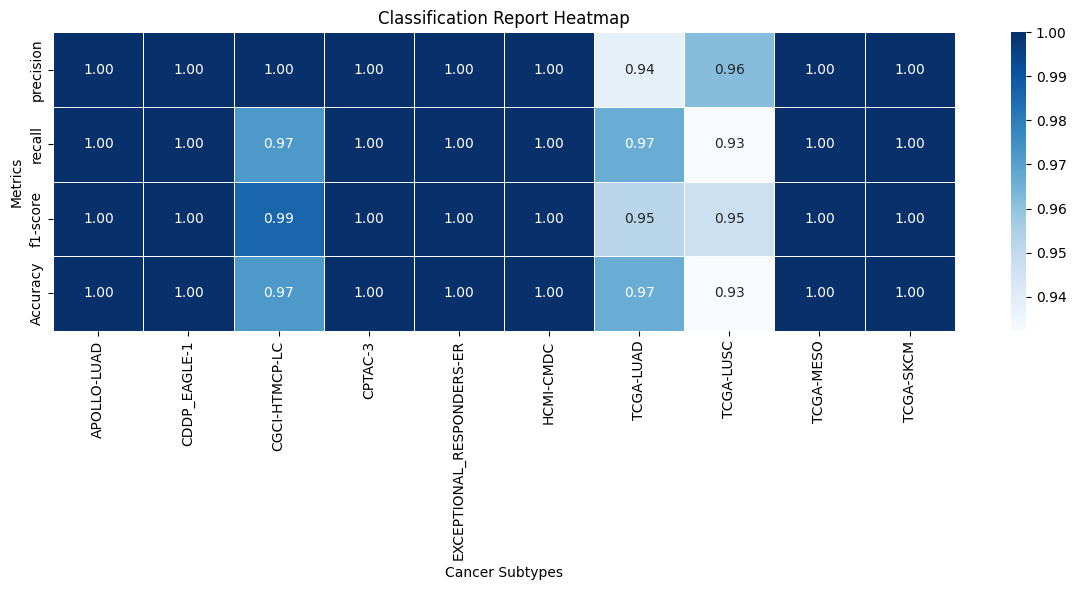

In [41]:
#just plotting horizontal graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd  # Make sure this is imported

# Confusion Matrix
cm = confusion_matrix(y_enc, y_pred)

# Report
report = classification_report(y_enc, y_pred, target_names=le.classes_, output_dict=True)


report_df = pd.DataFrame(report).transpose()

# accuracy for each subtype
accuracy_per_subtype = {}
for idx, label in enumerate(le.classes_):
    correct_predictions = cm[idx, idx]
    total_predictions = cm[idx, :].sum()
    accuracy_per_subtype[label] = correct_predictions / total_predictions

report_df = report_df.iloc[:-3, :-1]
report_df['Accuracy'] = report_df.apply(lambda row: accuracy_per_subtype[row.name] if row.name in accuracy_per_subtype else None, axis=1)

report_df_transposed = report_df.transpose()
plt.figure(figsize=(12, 6))
sns.heatmap(report_df_transposed, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Classification Report Heatmap')
plt.xlabel('Cancer Subtypes')
plt.ylabel('Metrics')
plt.tight_layout()
plt.show()
